## Обощенные линейные модели: примеры, регрессия

**Плюсы линейных моделей**:
 - легко интерпретируются. На выходе вы получаете коэффициенты, которые можно интерпретировать как величину отклика выхода на единичное изменение данного признака. Именно поэтому в анализе экспериментальных данных - это основной инструмент.
 - за ними стоит хорошо и давно разработанная теоретическая база, функция правдоподобия для всех GLM моделей "хорошая", гладках и оптимизационная задача имеет решение
 
**Минусы**:
  - Если у вас пространство признаков сложное, не разделимое линейно - то линейными моделями не добиться хорошего решения. 
  
Обшая идея: если вам нужен качественный анализ данных (страхование, банковская сфера, анализ эксперимента) - точно нужно начинать с линейных моделей.

Если у вас задача сделать качественный прогноз: победитель тот, кто дает лучшие метрики, но с линейных моделей всегда хорошо начинать и рассматривать их как базовую модель, чтобы не строить комбайн там, где можно обойтись без него   


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats as sts
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

# Этапы построения модели (общие идеи для любых моделей)

## Отложенная выборка
Вы строите модель, а потом планируете использовать ее на неизвестных данных, давайте имитируем это, и отложим какую-то часть выборки, на которой и будем смотреть качество модели. Если вы посмотрите как устроены данные на каггле, то там есть всегда тестовая выборка, и очень частая история, когда получается очень хорошая модель на обучающейся выборке, а на тесте качество очень плохое. Эта проблема известна как переобучение. В том, случае когда у вас нет отложенной выборки  - ее надо самостоятельно зарезервировать.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [9]:
data_boston = load_boston()
X, y = data_boston['data'], data_boston['target']
df_boston = pd.DataFrame(X, columns = data_boston['feature_names'])
df_boston['target'] = y
X_train, X_test, y_train, y_test = train_test_split(df_boston.iloc[:,:-1], df_boston.iloc[:,-1], test_size=0.15)

In [10]:
print(f'Посмотрим описательную статистику и на пропуски: {np.sum(df_boston.isnull().all())} пропусков')
df_boston.describe()

Посмотрим описательную статистику и на пропуски: 0 пропусков


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


**Признаки:**
- CRIM - количество преступлений на душу населения
- ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
- INDUS - процент площадей под оптовую торговлю 
- CHAS - протекает ли река
- NOX - концентрация оксидов азота
- RM - среднее число комнат в здании
- AGE - доля зданий, построенных до 1940 года 
- DIS - взвешенное расстояние до 5 деловых центров Бостона
- RAD - индекс доступности скоростных магистралей
- TAX - уровень налогов
- PTRATIO - среднее число учащихся на одного преподавателя 
- B - процент афроамериканцев
- LSTAT - процент граждан с низким уровнем жизни
- MEDV (целевой) - медианная стоимости домов в районе

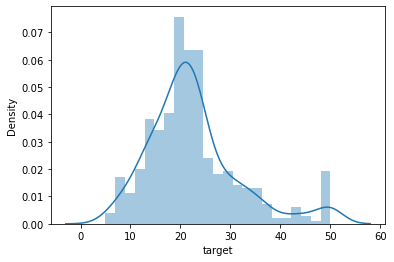

In [11]:
sns.distplot(df_boston['target'])

In [12]:
df_boston['cat_target'] = pd.cut(df_boston['target'],3)
df_boston['cat_B'] = pd.cut(df_boston['B'],2)
df_boston['cat_LSTAT'] = pd.cut(df_boston['LSTAT'],2)

Можно разбить дома на категории и посмотреть есть ли какие-то взаимосвязи


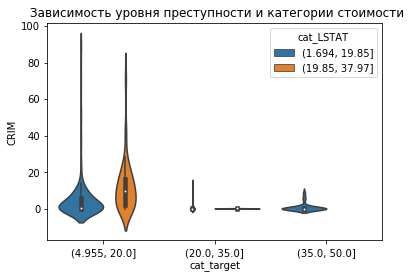

In [13]:
print('Можно разбить дома на категории и посмотреть есть ли какие-то взаимосвязи')
sns.violinplot(y = 'CRIM',x = 'cat_target', data=df_boston , hue = 'cat_LSTAT').set_title(' Зависимость уровня преступности и категории стоимости');

## Подбор моделей
Попробуем обучить несколько моделей и посмотрим как их можно интерпретировать

In [14]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet, LassoCV 

In [15]:
reg1 = LinearRegression()
reg1.fit(X_train,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(reg1.coef_,2))))))
print(reg1.intercept_)
print(f'Качество при обучении {reg1.score(X_train, y_train).round(2)}, качество на отложенной выборке {reg1.score(X_test, y_test).round(2)}')

('CRIM', -0.09)
('ZN', 0.04)
('INDUS', 0.04)
('CHAS', 1.85)
('NOX', -17.44)
('RM', 3.89)
('AGE', -0.0)
('DIS', -1.45)
('RAD', 0.3)
('TAX', -0.01)
('PTRATIO', -0.99)
('B', 0.01)
('LSTAT', -0.47)
36.302551401799924
Качество при обучении 0.75, качество на отложенной выборке 0.7


Можно пытаться искать смысл в коээффициентах, но в исходном виде это достаточно сложно. Почему? Что можно сделать?
Говорит ли вам о чем нибудь величина коэффициента? 


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg1_sc = LinearRegression()
reg1_sc.fit(X_train_scaled,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(reg1_sc.coef_,2))))))
print(reg1_sc.intercept_)
print(f'Качество при обучении {reg1_sc.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {reg1_sc.score(X_test_scaled, y_test).round(2)}')

('CRIM', -0.79)
('ZN', 1.05)
('INDUS', 0.28)
('CHAS', 0.46)
('NOX', -2.03)
('RM', 2.76)
('AGE', -0.11)
('DIS', -3.03)
('RAD', 2.55)
('TAX', -2.33)
('PTRATIO', -2.11)
('B', 0.94)
('LSTAT', -3.43)
22.414186046511677
Качество при обучении 0.75, качество на отложенной выборке 0.7


### Lasso - регрессия
так устроена, что зануляет _ненужные_ признаки

In [17]:
reg_lasso = Lasso(alpha=0.1)
reg_lasso.fit(X_train_scaled,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(reg_lasso.coef_,2))))))
print(reg_lasso.intercept_)
print(f'Качество при обучении {reg_lasso.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {reg_lasso.score(X_test_scaled, y_test).round(2)}')


('CRIM', -0.5)
('ZN', 0.71)
('INDUS', -0.0)
('CHAS', 0.43)
('NOX', -1.57)
('RM', 2.87)
('AGE', -0.0)
('DIS', -2.37)
('RAD', 1.15)
('TAX', -1.13)
('PTRATIO', -1.97)
('B', 0.84)
('LSTAT', -3.43)
22.414186046511677
Качество при обучении 0.74, качество на отложенной выборке 0.69


In [18]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(reg_lasso.coef_,2))))))
print(reg_lasso.intercept_)
print(f'Качество при обучении {reg_lasso.score(X_train, y_train).round(2)}, качество на отложенной выборке {reg_lasso.score(X_test, y_test).round(2)}')
print('Видим что всего несколько признаков дает почти такое же качество')

('CRIM', -0.08)
('ZN', 0.05)
('INDUS', -0.02)
('CHAS', 0.0)
('NOX', -0.0)
('RM', 3.52)
('AGE', -0.01)
('DIS', -1.09)
('RAD', 0.26)
('TAX', -0.02)
('PTRATIO', -0.79)
('B', 0.01)
('LSTAT', -0.53)
26.7195470318236
Качество при обучении 0.73, качество на отложенной выборке 0.67
Видим что всего несколько признаков дает почти такое же качество


In [19]:
reg_lasso = Lasso(alpha=0.01)
reg_lasso.fit(X_train_scaled,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(reg_lasso.coef_,2))))))
print(reg_lasso.intercept_)
print(f'Качество при обучении {reg_lasso.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {reg_lasso.score(X_test_scaled, y_test).round(2)}')
print('Видим что всего несколько признаков дает почти такое же качество')

('CRIM', -0.76)
('ZN', 1.01)
('INDUS', 0.19)
('CHAS', 0.46)
('NOX', -1.96)
('RM', 2.77)
('AGE', -0.09)
('DIS', -2.98)
('RAD', 2.39)
('TAX', -2.18)
('PTRATIO', -2.09)
('B', 0.93)
('LSTAT', -3.43)
22.414186046511677
Качество при обучении 0.75, качество на отложенной выборке 0.7
Видим что всего несколько признаков дает почти такое же качество


### Как выбирать параметры: кросс-валидация
Кроссвалидация - переразбиваем выборку на тестовую о обучающую несколько раз, для того чтобы исключить эффект "разбиения". Есть много разных стратегий как разбивать, самая частая - кросс валидация по нескольким последовательным фолдам

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/500px-K-fold_cross_validation_EN.svg.png" alt="Drawing" style="width: 400px;"/>

Для Lasso и Ridge есть отдельные классы, а есть общая обертка GridSearchCV, в которую можно отдать любую модель. В том случае, если у вас есть отдельная отложенная выборка для теста, то вадилировать можно на полном датасете. Если же нет - то отложенную выборку не трогаете. Настройка гиперпараметров - это тоже подстройка под данные, и тоже ведет к переобучению

In [20]:
lasso_cv = LassoCV(alphas =  np.logspace(-2, 1, 13), cv=3, normalize = True)
lasso_cv.fit(X, y)
list(zip(lasso_cv.alphas_.round(2), np.mean(lasso_cv.mse_path_, axis=1).round(2)))

[(10.0, 111.15),
 (5.62, 111.15),
 (3.16, 111.15),
 (1.78, 111.15),
 (1.0, 111.15),
 (0.56, 111.15),
 (0.32, 101.17),
 (0.18, 76.99),
 (0.1, 68.79),
 (0.06, 57.47),
 (0.03, 49.64),
 (0.02, 46.07),
 (0.01, 44.63)]

In [21]:
lasso_cv = LassoCV(alphas =  np.logspace(-2, 2, 13), cv=3)
lasso_cv.fit(X, y)
list(zip(lasso_cv.alphas_.round(2), np.mean(lasso_cv.mse_path_, axis=1).round(2)))

[(100.0, 85.41),
 (46.42, 80.77),
 (21.54, 67.0),
 (10.0, 53.75),
 (4.64, 53.23),
 (2.15, 55.08),
 (1.0, 47.83),
 (0.46, 45.87),
 (0.22, 43.0),
 (0.1, 46.39),
 (0.05, 61.78),
 (0.02, 73.01),
 (0.01, 107.37)]

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
grid = GridSearchCV(Lasso(normalize=True), {'alpha': np.logspace(-2, 2, 10)}, scoring = 'r2', cv=3)
grid.fit(X, y)
res = pd.DataFrame(grid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(grid.best_params_)
print(grid.best_score_)
res

{'alpha': 0.01}
0.3180917389808917


,params,mean_test_score,std_test_score,rank_test_score
0,{'alpha': 0.01},0.318092,0.367075,1
1,{'alpha': 0.027825594022071243},0.260620,0.367099,2
2,{'alpha': 0.0774263682681127},0.050295,0.472228,3
3,{'alpha': 0.21544346900318834},-0.230985,0.499389,4
4,{'alpha': 0.5994842503189409},-0.689073,0.473525,5
5,{'alpha': 1.6681005372000592},-0.689073,0.473525,5
6,{'alpha': 4.6415888336127775},-0.689073,0.473525,5
7,{'alpha': 12.915496650148826},-0.689073,0.473525,5
8,{'alpha': 35.93813663804626},-0.689073,0.473525,5
9,{'alpha': 100.0},-0.689073,0.473525,5


In [24]:
grid = GridSearchCV(Ridge(normalize=True), {'alpha': np.logspace(-2, 1, 10)}, scoring = 'r2', cv=5)
grid.fit(X, y)
res = pd.DataFrame(grid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(grid.best_params_)
print(grid.best_score_)
res

{'alpha': 0.21544346900318834}
0.47973553092236887


,params,mean_test_score,std_test_score,rank_test_score
0,{'alpha': 0.01},0.373280,0.360321,7
1,{'alpha': 0.021544346900318832},0.391697,0.345212,6
2,{'alpha': 0.046415888336127774},0.420121,0.320617,5
3,{'alpha': 0.1},0.453923,0.285513,3
4,{'alpha': 0.21544346900318834},0.479736,0.240301,1
5,{'alpha': 0.46415888336127775},0.478192,0.188384,2
6,{'alpha': 1.0},0.426605,0.146157,4
7,{'alpha': 2.154434690031882},0.307930,0.148008,8
8,{'alpha': 4.6415888336127775},0.119480,0.232067,9
9,{'alpha': 10.0},-0.118292,0.404347,10


In [25]:
reg_ridge = Ridge(alpha=0.21)
reg_ridge.fit(X_train_scaled,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(reg_ridge.coef_,2))))))
print(reg_ridge.intercept_)
print(f'Качество при обучении {reg_ridge.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {reg_ridge.score(X_test_scaled, y_test).round(2)}')


('CRIM', -0.79)
('ZN', 1.04)
('INDUS', 0.27)
('CHAS', 0.46)
('NOX', -2.02)
('RM', 2.76)
('AGE', -0.11)
('DIS', -3.03)
('RAD', 2.53)
('TAX', -2.32)
('PTRATIO', -2.11)
('B', 0.94)
('LSTAT', -3.43)
22.414186046511677
Качество при обучении 0.75, качество на отложенной выборке 0.7


### Elastic net

In [26]:
param_grid = {'alpha': np.logspace(-2, 1, 10),
              'l1_ratio': [0.01, .1, .5, .9, .98, 1]}
grid = GridSearchCV(ElasticNet(normalize=True), param_grid, scoring = 'r2', cv=5)
grid.fit(X, y)
res = pd.DataFrame(grid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(grid.best_params_)
print(grid.best_score_)
res.sort_values('rank_test_score').head(5)

{'alpha': 0.01, 'l1_ratio': 0.9}
0.4465975306125188


,params,mean_test_score,std_test_score,rank_test_score
3,"{'alpha': 0.01, 'l1_ratio': 0.9}",0.446598,0.210707,1
4,"{'alpha': 0.01, 'l1_ratio': 0.98}",0.424293,0.304326,2
5,"{'alpha': 0.01, 'l1_ratio': 1}",0.402426,0.330235,3
10,"{'alpha': 0.021544346900318832, 'l1_ratio': 0.98}",0.396950,0.290237,4
11,"{'alpha': 0.021544346900318832, 'l1_ratio': 1}",0.386125,0.326297,5


In [27]:
reg_elnet = ElasticNet(alpha = 0.01, l1_ratio = 0.9)
reg_elnet.fit(X_train_scaled,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(reg_elnet.coef_,2))))))
print(reg_ridge.intercept_)
print(f'Качество при обучении {reg_elnet.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {reg_elnet.score(X_test_scaled, y_test).round(2)}')


('CRIM', -0.76)
('ZN', 1.01)
('INDUS', 0.19)
('CHAS', 0.46)
('NOX', -1.96)
('RM', 2.77)
('AGE', -0.09)
('DIS', -2.97)
('RAD', 2.37)
('TAX', -2.16)
('PTRATIO', -2.09)
('B', 0.93)
('LSTAT', -3.42)
22.414186046511677
Качество при обучении 0.75, качество на отложенной выборке 0.7


## Попробуем теперь регрессию с Гамма распределением

In [28]:
from sklearn.linear_model import GammaRegressor
reg_gamma = GammaRegressor()
reg_gamma.fit(X_train_scaled,y_train)
print('\n'.join(map(str,list(zip(data_boston['feature_names'], np.round(np.exp(reg_gamma.coef_),2))))))
print(np.exp(reg_gamma.intercept_))
print(f'Качество при обучении {reg_gamma.score(X_train_scaled, y_train).round(2)}, качество на отложенной выборке {reg_gamma.score(X_test_scaled, y_test).round(2)}')


('CRIM', 0.97)
('ZN', 1.01)
('INDUS', 0.98)
('CHAS', 1.02)
('NOX', 0.97)
('RM', 1.07)
('AGE', 0.98)
('DIS', 0.98)
('RAD', 0.99)
('TAX', 0.97)
('PTRATIO', 0.96)
('B', 1.03)
('LSTAT', 0.92)
21.273072632170965
Качество при обучении 0.68, качество на отложенной выборке 0.56


Ну получилось так себе, зато можно интерпретировать немножко по другому

## Анализ остатков

При оценке регрессии, любой, какой угодно в том числе логистической важно, чтобы остатки модели были распределены нормально, 
то есть распределение ошибок должно быть хорошее. 

### Разложение ошибки на смещение и разброс (Bias-variance decomposition) (взято с mlcourse.ai)

Поговорим немного о свойствах оценки, полученной линейной регрессией. В свете предыдущего пункта мы выяснили, что:
- истинное значение целевой переменной складывается из некоторой детерминированной функции $f(\textbf{x})$ и случайной ошибки $\epsilon$: $y = f\left(\textbf{x}\right) + \epsilon$;
- ошибка распределена нормально с центром в нуле и некоторым разбросом: $\epsilon \sim \mathcal{N}\left(0, \sigma^2\right)$;
- истинное значение целевой переменной тоже распределено нормально: $y \sim \mathcal{N}\left(f\left(\textbf{x}\right), \sigma^2\right)$
- мы пытаемся приблизить детерминированную, но неизвестную функцию $f\left(\textbf{x}\right)$ линейной функцией от регрессоров $\widehat{f}\left(\textbf{x}\right)$, которая, в свою очередь, является точечной оценкой функции $f$ в пространстве функций (точнее, мы ограничили пространство функций параметрическим семейством линейных функций), т.е. случайной переменной, у которой есть среднее значение и дисперсия.

Тогда ошибка в точке $\textbf{x}$ раскладывается следующим образом (пропустила все выкладки https://mlcourse.ai/articles/topic4-part1-linreg/):


 $y = f\left(\textbf{x}\right) + \epsilon$ складывается из:

- квадрата смещения: $\text{Bias}\left(\widehat{f}\right)$ – средняя ошибка по всевозможным наборам данных;
- дисперсии: $\text{Var}\left(\widehat{f}\right)$ – вариативность ошибки, то, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных;
- неустранимой ошибки: $\sigma^2$.

Если с последней мы ничего сделать не можем, то на первые два слагаемых мы можем как-то влиять. В идеале, конечно же, хотелось бы свести на нет оба этих слагаемых (левый верхний квадрат рисунка), но на практике часто приходится балансировать между смещенными и нестабильными оценками (высокая дисперсия).

<img src="https://miro.medium.com/max/544/1*Y-yJiR0FzMgchPA-Fm5c1Q.jpeg" width="480">

Как правило, при увеличении сложности модели (например, при увеличении количества свободных параметров) уменьшается дисперсия (разброс) оценки, но оценка становится смещенной. Из-за того что тренировочный набор данных полностью запоминается вместо обобщения, небольшие изменения приводят к неожиданным результатам (переобучение). Если же модель слабая, то она не в состоянии выучить закономерность, в результате выучивается что-то другое, смещенное относительно правильного решения.

<img src="https://miro.medium.com/max/492/1*blqnaVEu6Hbc-5ZYeDnU9Q.png" width="480">

Теорема Маркова-Гаусса как раз утверждает, что МНК-оценка параметров линейной модели является самой лучшей в классе несмещенных линейных оценок, то есть с наименьшей дисперсией. Это значит, что если существует какая-либо другая несмещенная модель $g$ тоже из класса линейных моделей, то мы можем быть уверены, что $Var\left(\widehat{f}\right) \leq Var\left(g\right)$.

Что это значит? Есть смысл смотреть как изменяются ошибки при обучении моделей

Можно нарисовать их самостоятельно


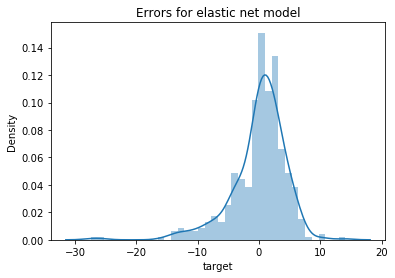

In [29]:
print('Можно нарисовать их самостоятельно')
sns.distplot(reg_elnet.predict(X_train_scaled) - y_train).set_title('Errors for elastic net model');

In [30]:
from yellowbrick.regressor import ResidualsPlot

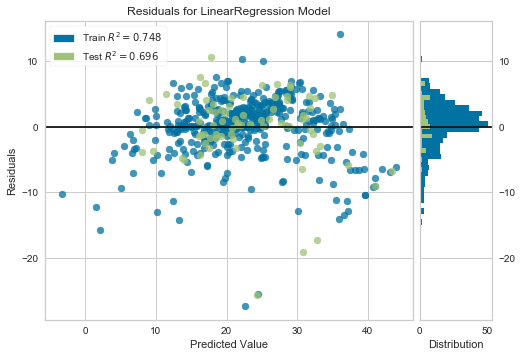

In [31]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

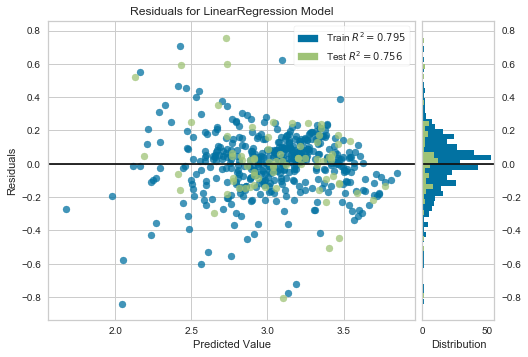

In [32]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train_scaled, np.log(y_train))
visualizer.score(X_test_scaled, np.log(y_test))
visualizer.show()

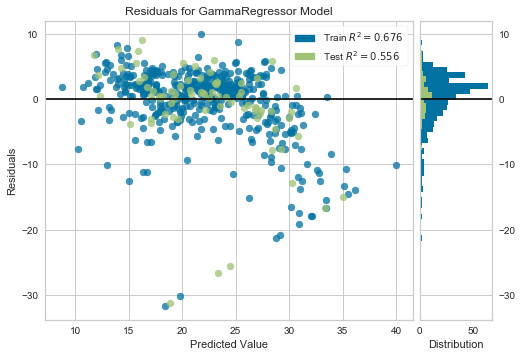

In [33]:
visualizer = ResidualsPlot(GammaRegressor())
visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

In [34]:
param_grid = {'alpha': np.logspace(-3, 0, 10),
              'l1_ratio': [0.01, .1, .5, .9, .98, 1]}
grid = GridSearchCV(ElasticNet(normalize=True), param_grid, cv=5)
grid.fit(X, np.log(y))
res = pd.DataFrame(grid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(grid.best_params_)
print(grid.best_score_)
res.sort_values('rank_test_score').head(5)

{'alpha': 0.001, 'l1_ratio': 0.01}
0.610435181466191


,params,mean_test_score,std_test_score,rank_test_score
0,"{'alpha': 0.001, 'l1_ratio': 0.01}",0.610435,0.120936,1
1,"{'alpha': 0.001, 'l1_ratio': 0.1}",0.608293,0.123524,2
2,"{'alpha': 0.001, 'l1_ratio': 0.5}",0.593907,0.137596,3
3,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.569570,0.143389,4
4,"{'alpha': 0.001, 'l1_ratio': 0.98}",0.562079,0.146273,5


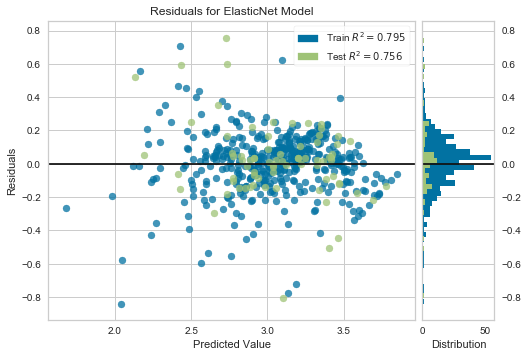

In [35]:
visualizer = ResidualsPlot(ElasticNet(alpha = 0.001, l1_ratio = 0.01))
visualizer.fit(X_train_scaled, np.log(y_train))
visualizer.score(X_test_scaled, np.log(y_test))
visualizer.show()

### Выбор моделей
После того как вы выбрали параметры, надо еще модели выбрать. Выбираем мы их опять же с помощью кросс валидации. Дальше больше, можно сделать блендинг моделей, опять же с помощью кросс-валидации

In [38]:
from sklearn.model_selection import cross_val_score

In [39]:
print(cross_val_score(ElasticNet(alpha = 0.001, l1_ratio = 0.01), X_train_scaled, y_train, cv=3))

[0.73435929 0.67165405 0.69964622]


# Итак, общая схема такая:
     - Разбили данные на трейн и тест
     - Обучились на трейне, подобрали параметры, модель, выбор по кросс валидации
     - Посмотрели на остатки, убедились, что все ок
     - Получили оценку качества на тесте
     - И вишенка на торте: запихнули все в AutoMl и посмотрели что он предлагает. Можно выбрать лучшую модель и одну ее запустить с параметрами, посмотреть как работает 